In [1]:
from ema import read

In [2]:
meal_info = read.all_meal_info()

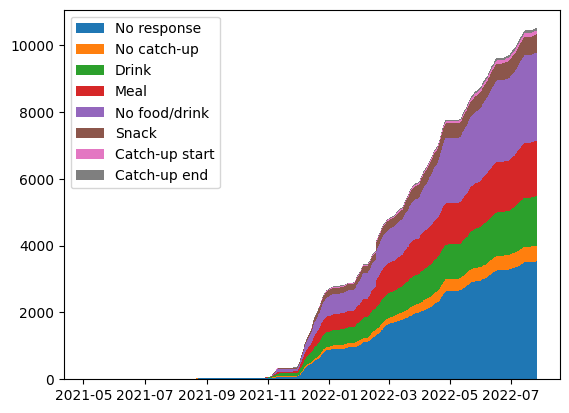

In [21]:
"""
Plot a cumulative histogram showing the number of each type of meal

"""
import pandas as pd
import matplotlib.pyplot as plt

min_time, max_time = meal_info.index.min(), meal_info.index.max()

fig, axis = plt.subplots()
bins = pd.date_range(min_time, max_time, freq="1H")

labels = meal_info["meal_type"].unique()
data = [meal_info[meal_info["meal_type"] == meal_type].index for meal_type in labels]
axis.hist(data, bins=bins, stacked=True, label=labels, cumulative=True)

axis.legend()